# ACS6420 Advanced project
## Rolls-Royce Undergraduate project - Anomaly detection in discrete sequences
### Author: Aldair M Silva
### Supervisor: Visakan
Date created: 13/10/2021

In [1]:
from datetime import date
print('Updated: ', date.today().strftime('%d/%m/%Y'))

Updated:  10/05/2022


Import libraries

In [123]:
import io
import re
import csv
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve

In [14]:
random.seed(1)

Import data

In [15]:
normal_raw = 'normalTrafficTraining.txt'
anomaly_raw = 'anomalousTrafficTest.txt'

normal_parse = 'normalRequestTraining.txt'
anomaly_parse = 'anomalousRequestTest.txt'

## Prototype 1

### File handling functions

In [125]:
# Remove punctuation from text
def removepunctuation(text):
    new_text = text.translate(str.maketrans('', '', string.punctuation))
    return new_text

# File parsing function
def parse_file(file_in, file_out):
    fin = open(file_in)
    fout = io.open(file_out, "w", encoding="utf-8")
    lines = fin.readlines()
    res = []
    
    for i in range(len(lines)):
        line = lines[i].strip()
        line = removepunctuation(line) # remove punctuation from each line
        if line.startswith("GET"):
            res.append("GET" + line.split(" ")[1])
        elif line.startswith("POST") or line.startswith("PUT"):
            url = line.split(' ')[0] + line.split(' ')[1]
            j = 1
            while True:
                if lines[i + j].startswith("Content-Length"):
                    break
                j += 1
            j += 1
            data = lines[i + j + 1].strip()
            url += '?' + data
            res.append(url)
    for line in res:
        line = urllib.parse.unquote(line).replace('\n','').lower()
        fout.writelines(line + '\n')
    print ("finished parse ",len(res)," requests")
    fout.close()
    fin.close()

# File reading function
def loadData(file):
    with open(file, 'r', encoding="utf8") as f:
        data = f.readlines()
    result = []
    for d in data:
        d = d.strip()
        if (len(d) > 0):
            result.append(d)
    return result

### Learning curve function

In [128]:
 def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.subplots(1, figsize=(10,10))
    plt.plot(train_sizes, train_mean, '--', color="black",  label="Training score")
    plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [42]:
normal_data = parse_file(normal_raw,normal_parse)
anomaly_data = parse_file(anomaly_raw,anomaly_parse)

finished parse  36000  requests
finished parse  25065  requests


In [43]:
good_requests = loadData('normalRequestTraining.txt')
bad_requests = loadData('anomalousRequestTest.txt')

all_requests = bad_requests + good_requests
yBad = [1] * len(bad_requests)
yGood = [0] * len(good_requests)
y = yBad + yGood

In [44]:
idx_random = np.random.randint(0,len(all_requests), 35000)
short_all_request = [all_requests[i] for i in idx_random]
y_short = [y[i] for i in idx_random]
idx_random

array([57806, 30107, 41073, ..., 11919,  8153, 35646])

In [45]:
len(short_all_request)

35000

In [46]:
len(y_short)

35000

### Doc2Vector

    This section uses TF-IDF (Term frequency-Inverse Document Frequency) to transform the words in the document into numberical values.
The values are determines by how many times they appear in the document, and the inverse frequency of the same word in other documents/corpus.
This process is called "vectorization", and is calculated as tf=log[1+fre(term,document)], idf=log(1+total_number_of_pages/number_of_pages_containing_term).
Both resutls are then multiplied. The values range from 0 to 1, 0 being very relevant and 1 being less relevant.
Relevance in this case means the word is unique (less common/less frequent) in and across documents, and the opposite for less relevant words (such as what/the/is/in for instance).

For this text analysis, the words will be taken as characters due to the nature of the document (web request), resulting in roughly 62 features extracted from 61065 requests)

In [47]:
vectorizer = TfidfVectorizer(min_df=0.0, analyzer="char", sublinear_tf=True, ngram_range=(1, 1))
X = vectorizer.fit_transform(all_requests)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
pd.DataFrame(X_train[:])
X.shape 

(61065, 61)

Feature analysis will show all the characters used as features. As it can be observed below, numbers, letters, special and unknwon characters are taken into account. 
The unknown features in this model exist because the vectorizer works in english language, and the document contains latin words/characters, although not very frequent.

In [48]:
# Analysis of features extracted

feature_array = np.array(vectorizer.get_feature_names())    # Get feature names
print("Feature names: ", feature_array)

X_dense = X.todense()


Feature names:  ['!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1' '2'
 '3' '4' '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '@' '_' 'a' 'b' 'c'
 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u'
 'v' 'w' 'x' 'y' 'z' '|' '�']


In [49]:
np.where(X_dense[0,:])[1]

array([15, 16, 17, 18, 20, 22, 23, 24, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55])

In [85]:
print("X vector matrix: \n", X_dense[1,:])
print("\nMax value in vector: ", np.max(X_dense))
print("Min value in vector: ", np.min(X_dense))

X vector matrix: 
 [[0.         0.         0.         0.         0.18798904 0.25161667
  0.31947476 0.         0.         0.23671082 0.37484082 0.
  0.         0.         0.         0.06833697 0.07050507 0.07680554
  0.         0.         0.09184648 0.         0.         0.08470192
  0.         0.         0.36068321 0.         0.23410443 0.
  0.08971451 0.         0.         0.14687569 0.12958823 0.11889963
  0.12635574 0.13329536 0.07598724 0.         0.08470192 0.14220344
  0.07960001 0.12500525 0.11889963 0.12613926 0.11482017 0.14388462
  0.11267797 0.         0.17173463 0.11889963 0.13329536 0.11032396
  0.         0.09184648 0.         0.         0.         0.
  0.28044006]]

Max value in vector:  0.7815199018968937
Min value in vector:  0.0


In [51]:
# Features.csv gets created in the current working directory
#with open('Features.csv', 'w', newline = '') as csvfile:
#    my_writer = csv.writer(csvfile, delimiter = ' ')
#    my_writer.writerow(X_array)


### PCA
Explore how components affect model dimensions.
Understand how relevant the method is to identify best features that can best pick anomalous data.
Check explained variance ratios, try using a treshold to separate best features.

In [52]:
short_X_dense = X_dense[:35000,:]
pca = PCA(n_components=7, svd_solver='full')
X_PCA = pca.fit_transform(short_X_dense)
X_embedded = TSNE(n_components=2).fit_transform(short_X_dense)

Understand and evaluate the meaning of variance in PCA dataset.

Through experiments, it has been noticed that the number of X_dense values selected has a direct correlation with the variance ratio. Having about 47% of the dataset represented overall, with around 35,000 points. with PCA1 having the highest portion.

In [53]:
print("Variance ratio: ", pca.explained_variance_ratio_)
print("Singular values: ", pca.singular_values_)

Variance ratio:  [0.26226915 0.16234657 0.06783786 0.05398874 0.04074158 0.03603102
 0.0319591 ]
Singular values:  [54.67623365 43.01763699 27.80744246 24.80713454 21.54983361 20.26577628
 19.08632219]


PCA plots

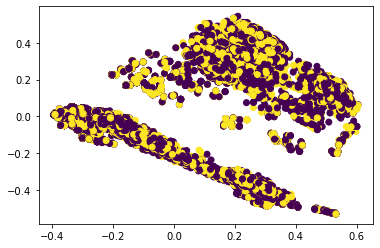

In [54]:
# Scatter plot
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y_short)


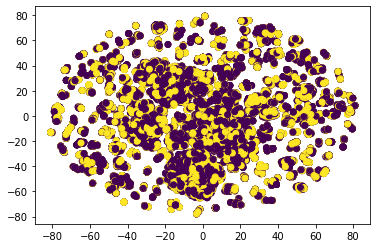

In [55]:
# Linear plot
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y_short)

### Logistic regression model

Score Logistic Regression : 0.7994541484716157
Confusion Matrix: 
[[9614 1231]
 [2443 5032]]


/Users/audazmm/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


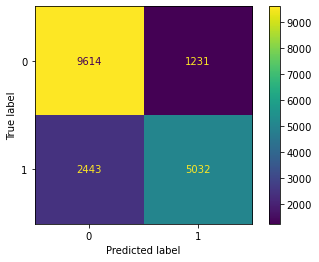

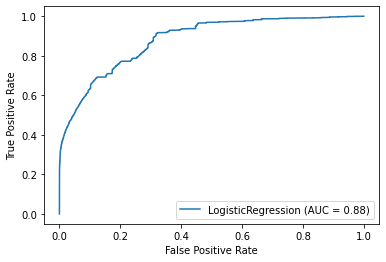

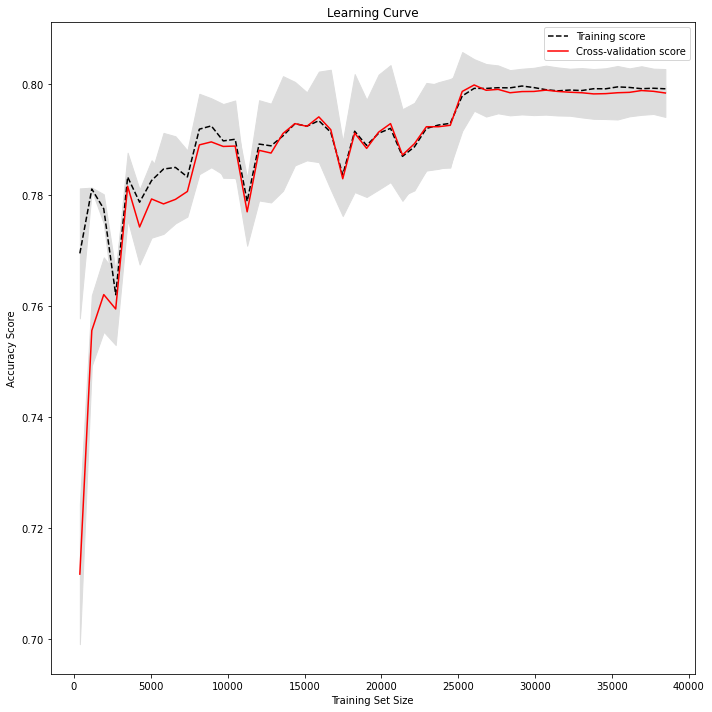

In [129]:
lgs = LogisticRegression()
lgs.fit(X_train, y_train)
y_pred = lgs.predict(X_test)
score_test = metrics.accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print ("Score Logistic Regression :",score_test)
print ("Confusion Matrix: ")
print (matrix)
plot_confusion_matrix(lgs, X_test, y_test)
plt.show()

metrics.plot_roc_curve(lgs, X_test, y_test)
plot_learning_curve(lgs, X_train, y_train)

### Decision tree model
Write on understanding of rules.
    - What do numbers mean for tree.plot_tree()

Plot decision tree.

Score Decesion Tree : 0.8130458515283843
Confusion Matrix: 
[[9690 1155]
 [2270 5205]]


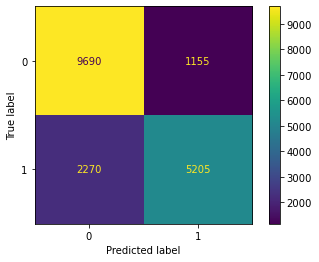

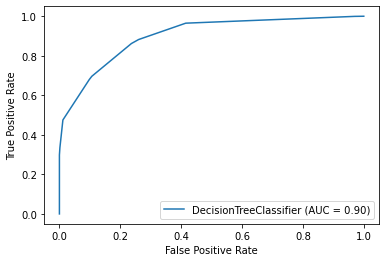

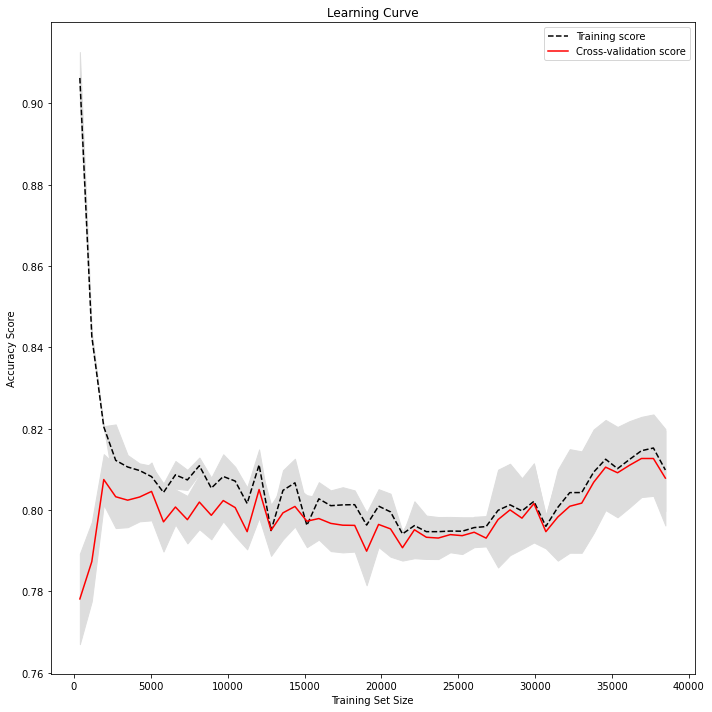

In [130]:
dtc = tree.DecisionTreeClassifier(max_depth=5)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
score_test = metrics.accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print ("Score Decesion Tree :",score_test)
print ("Confusion Matrix: ")
print (matrix)
plot_confusion_matrix(dtc, X_test, y_test)
plt.show()

metrics.plot_roc_curve(dtc, X_test, y_test)
plot_learning_curve(dtc, X_train, y_train)

[Text(148.8, 190.26, 's <= 0.196\ngini = 0.484\nsamples = 42745\nvalue = [25155, 17590]'),
 Text(74.4, 135.9, 'n <= 0.103\ngini = 0.462\nsamples = 20168\nvalue = [7291, 12877]'),
 Text(37.2, 81.53999999999999, 'gini = 0.0\nsamples = 2708\nvalue = [0, 2708]'),
 Text(111.60000000000001, 81.53999999999999, 'r <= 0.293\ngini = 0.486\nsamples = 17460\nvalue = [7291, 10169]'),
 Text(74.4, 27.180000000000007, '\n  (...)  \n'),
 Text(148.8, 27.180000000000007, '\n  (...)  \n'),
 Text(223.20000000000002, 135.9, '1 <= 0.094\ngini = 0.33\nsamples = 22577\nvalue = [17864, 4713]'),
 Text(186.0, 81.53999999999999, 'gini = 0.0\nsamples = 1423\nvalue = [0, 1423]'),
 Text(260.40000000000003, 81.53999999999999, 'w <= 0.201\ngini = 0.263\nsamples = 21154\nvalue = [17864, 3290]'),
 Text(223.20000000000002, 27.180000000000007, '\n  (...)  \n'),
 Text(297.6, 27.180000000000007, '\n  (...)  \n')]

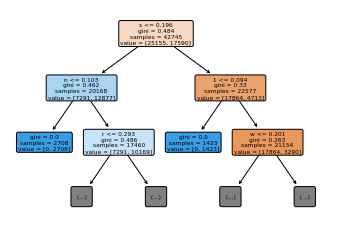

In [114]:
tree.plot_tree(dtc,feature_names=feature_array,
               max_depth=2,
              filled=True,rounded=True)

### SVM model

Score Linear SVM : 0.8045305676855895
Confusion Matrix: 
[[9634 1211]
 [2370 5105]]


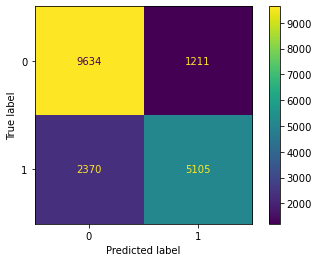

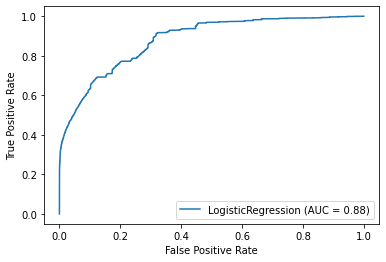

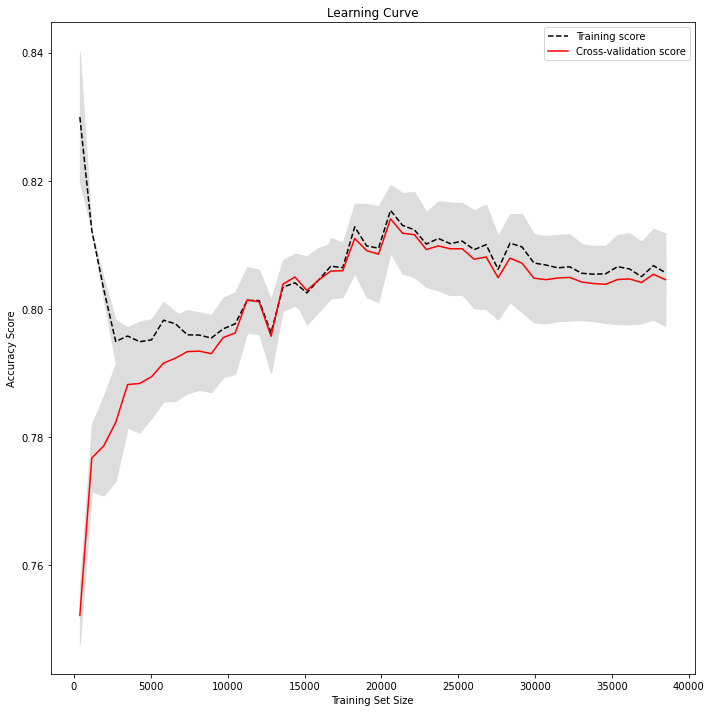

In [131]:
linear_svm=LinearSVC(C=1)
linear_svm.fit(X_train, y_train)
y_pred = linear_svm.predict(X_test)
score_test = metrics.accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print ("Score Linear SVM :",score_test)
print ("Confusion Matrix: ")
print (matrix)
plot_confusion_matrix(linear_svm, X_test, y_test)
plt.show()

metrics.plot_roc_curve(lgs, X_test, y_test)
plot_learning_curve(linear_svm, X_train, y_train)

### Random forest model

Write on rules used for random forest models

Score Random Forest : 0.9272925764192139
Confusion Matrix: 
[[10154   691]
 [  641  6834]]


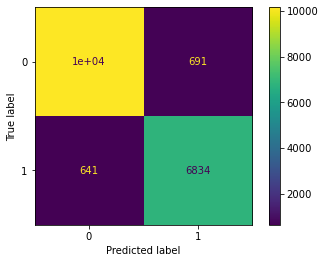

In [ ]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
score_test = metrics.accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)

print ("Score Random Forest :",score_test)
print ("Confusion Matrix: ")
print (matrix)
plot_confusion_matrix(rfc, X_test, y_test)
plt.show()

metrics.plot_roc_curve(lgs, X_test, y_test)
plot_learning_curve(rfc, X_train, y_train)

### Bootstrap Aggregation (Bagging) model

In [ ]:
# define the model
bag = BaggingClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(bag, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)

print ("Score Bagging Classifier :",score_test)
print ("Confusion Matrix: ")
print (matrix)
plot_confusion_matrix(bag, X_test, y_test)
plt.show()

#rfc.plot_tree(rf_ranom)

metrics.plot_roc_curve(bag, X_test, y_test)
plot_learning_curve(bag, X_train, y_train)